## Polar Sea Ice Prediction
Code for Ensemble LSTM model

## Initial Setup

In [30]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [32]:
import os
import math
from math import sqrt
import glob
import numpy as np
from numpy.random import seed
import pandas as pd
import matplotlib.pyplot as plt
import csv

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate, Permute, Reshape
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Flatten
from tensorflow.keras.layers import Layer

from sklearn.metrics import mean_squared_error

seed_number = 1
seed(seed_number)

In [33]:
# Define paths to load data
path = '/content/drive/MyDrive/SYDE 675/Project/Data'

daily_data_path = path + '/dailyt30_features.npy'
daily_target_path = path + '/monthly_features.npy'

monthly_data_path = path + '/monthly_features.npy'
monthly_target_path = path + '/monthly_target.npy'

daily_data = np.load(daily_data_path, allow_pickle=True)
monthly_data = np.load(monthly_data_path, allow_pickle=True)

daily_target = np.load(daily_target_path, allow_pickle=True)
monthly_target = np.load(monthly_target_path, allow_pickle=True)

In [34]:
print("Shape of daily data = ", daily_data.shape)
print("Shape of monthly data = ", monthly_data.shape)
print("Shape of monthly target data = ", monthly_target.shape)

Shape of daily data =  (480, 30, 11)
Shape of monthly data =  (480, 1, 11)
Shape of monthly target data =  (480,)


In [35]:
# Concatenate datasets
data = np.concatenate((daily_data, monthly_data), axis = 1)
print("Concatenated dataset = ", data.shape)

Concatenated dataset =  (480, 31, 11)


In [36]:
# Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
monthly_target = monthly_target[lag:]

print(data.shape)
print(monthly_target.shape)

(479, 31, 11)
(479,)


## Train Test Features Split

In [37]:
# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) # total number of datapoints

NUM_TRAIN = LEN_DATA - (12*5) # reserve last 5 years for testing 
NUM_TEST = LEN_DATA - NUM_TRAIN

print('LEN_DATA:', LEN_DATA)
print('NUM_TRAIN:', NUM_TRAIN)
print('NUM_TEST:', NUM_TEST)

x_train = data[0 : NUM_TRAIN]
x_test = data[NUM_TRAIN :]

# Split features and labels
y_train = monthly_target[ : NUM_TRAIN] # target is last column i-e sea-ice
y_test = monthly_target[NUM_TRAIN : ] # target is last column i-e sea-ice

LEN_DATA: 479
NUM_TRAIN: 419
NUM_TEST: 60


In [38]:
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (419, 31, 11)
y_train.shape: (419,)
x_test.shape: (60, 31, 11)
y_test.shape: (60,)


## Reshaping Input and Target Features

In [ ]:
# Convert an array of values into a 3D dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

## Normalization


In [39]:
#  Normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2])) # reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[2])) # reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) # reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) # reshaping to 2d for standard scaling

In [40]:
# All data will be in 2D after Standard Scaling
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (12989, 11)
y_train.shape: (419, 1)
x_test.shape: (1860, 11)
y_test.shape: (60, 1)


In [42]:
# Reshaping data to 3D for modeling
timesteps = 31
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_test = reshape_features(x_test, timesteps) # reshaping to 3d for model

(12989, 11)
(1860, 11)


In [43]:
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (419, 31, 11)
y_train.shape: (419, 1)
x_test.shape: (60, 31, 11)
y_test.shape: (60, 1)


# LSTM Network

## Attention layer

In [44]:
# Customized implementation of Attention layer to accomodate multiple calls to attention
class Attention(Layer):

    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28, philipperemy.
        """
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False)(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,))(hidden_states)
        score = Dot(axes=[1, 2])([h_t, score_first_part])
        attention_weights = Activation('softmax')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1])([hidden_states, attention_weights])
        pre_activation = Concatenate()([context_vector, h_t])
        attention_vector = Dense(self.units, use_bias=False, activation='tanh')(pre_activation)
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Model building

In [45]:
model1_input= Input(shape=(30,11))
model2_input= Input(shape=(1,11))

model1 = Permute((2,1), input_shape=(30,11))(model1_input)
model1 = LSTM(64, return_sequences=True)(model1)
model1 = Dropout(0.2)(model1)
model1 = LSTM(32, return_sequences=True)(model1)
model1 = Attention()(model1)
model1 = Dense(1)(model1)

model2 = Permute((2,1), input_shape=(1,11))(model2_input)
model2 = LSTM(64, return_sequences=True)(model2)
model2 = Dropout(0.2)(model2)
model2 = LSTM(32, return_sequences=True)(model2)
model2 = Attention()(model2)
model2 = Dense(1)(model2)

ensemble = concatenate([model1, model2])
merged_model = Dense(1)(ensemble)

model = Model(inputs=[model1_input, model2_input], outputs=merged_model)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30, 11)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1, 11)]      0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 11, 30)       0           ['input_3[0][0]']                
                                                                                                  
 permute_3 (Permute)            (None, 11, 1)        0           ['input_4[0][0]']                
                                                                                            

## Model Compilation

In [46]:
# Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')

## Model training on entire dataset

In [47]:
history = model.fit([x_train[:, :30, :],
                    x_train[:, 30:31, :]],
                    y_train,
                    epochs=100,
                    batch_size=64,
                    verbose=2,
                    shuffle=True)

Epoch 1/100
7/7 - 10s - loss: 0.7980 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 0s - loss: 0.2268 - 188ms/epoch - 27ms/step
Epoch 3/100
7/7 - 0s - loss: 0.1660 - 198ms/epoch - 28ms/step
Epoch 4/100
7/7 - 0s - loss: 0.1316 - 187ms/epoch - 27ms/step
Epoch 5/100
7/7 - 0s - loss: 0.0932 - 198ms/epoch - 28ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0844 - 200ms/epoch - 29ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0777 - 183ms/epoch - 26ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0681 - 212ms/epoch - 30ms/step
Epoch 9/100
7/7 - 0s - loss: 0.0602 - 183ms/epoch - 26ms/step
Epoch 10/100
7/7 - 0s - loss: 0.0549 - 182ms/epoch - 26ms/step
Epoch 11/100
7/7 - 0s - loss: 0.0504 - 218ms/epoch - 31ms/step
Epoch 12/100
7/7 - 0s - loss: 0.0442 - 183ms/epoch - 26ms/step
Epoch 13/100
7/7 - 0s - loss: 0.0449 - 192ms/epoch - 27ms/step
Epoch 14/100
7/7 - 0s - loss: 0.0361 - 191ms/epoch - 27ms/step
Epoch 15/100
7/7 - 0s - loss: 0.0325 - 185ms/epoch - 26ms/step
Epoch 16/100
7/7 - 0s - loss: 0.0298 - 197ms/epoch - 28ms/step
Epoc

## Model Predictions

In [48]:
trainPred = model.predict([x_train[:,:30,:], x_train[:,30:31,:]])
testPred = model.predict([x_test[:,:30,:], x_test[:,30:31,:]])
print(testPred.shape)
print(trainPred.shape)

(60, 1)
(419, 1)


In [49]:
# Reverting data back to 2D from 3D
x_train_t = x_train.reshape(-1, x_train.shape[2])
x_test_t = x_test.reshape(-1, x_test.shape[2])

print(x_train_t.shape)
print(trainPred.shape)
print(x_test_t.shape)
print(testPred.shape)

(12989, 11)
(419, 1)
(1860, 11)
(60, 1)


In [50]:
# Invert scaling for forecasted values 
inv_testPred = scaler_l.inverse_transform(testPred)
print("Sample of inverted predited values = ", inv_testPred[0])

# Invert scaling for actual values
inv_y_test = scaler_l.inverse_transform(y_test)
print("Sampe of inverted actual values = ", inv_y_test[0])

Sample of inverted predited values =  [14200995.]
Sampe of inverted actual values =  [13859281.]


In [51]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_testPred))
print('Test RMSE: %.3f' % rmse)

# Calculate Normalized RMSE
y_max = y_test.max()
y_min = y_test.min()
nrmse = rmse /(inv_y_test.mean()) 
print('Test NRMSE:', nrmse)

# Calculate R-square
r_sq = r2_score(inv_y_test, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test RMSE: 511455.030
Test NRMSE: 0.0477724518851075
Test R_Square: 0.976


# Write scores in csv files

In [52]:
file_path = '/content/drive/MyDrive/SYDE 675/Project/Models/ea-LSTM/ea_lstm_scores.csv'

header = ['seed', 'Test RMSE', 'Test normalized RMSE', 'R_Square']

if os.path.exists(file_path):
  # If file exists, append row
  with open(file_path, 'a', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the data
    writer.writerow([seed_number, rmse, nrmse, r_sq])

else:
  # If file does not exist, write new file
  with open(file_path, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow([seed_number, rmse, nrmse, r_sq])

In [53]:
results = pd.read_csv(file_path)
results.describe()

,seed,Test RMSE,Test normalized RMSE,R_Square
count,21.000000,21.000000,21.000000,21.000000
mean,1.476190,618914.229106,0.057810,0.964148
std,0.511766,55528.535575,0.005187,0.006559
min,1.000000,507946.423174,0.047445,0.948826
25%,1.000000,588577.846506,0.054976,0.960888
50%,1.000000,604819.099372,0.056493,0.966023
75%,2.000000,648919.689737,0.060612,0.967823
max,2.000000,742264.260221,0.069331,0.976036


# Plotting

Text(0, 0.5, 'SIE Values')

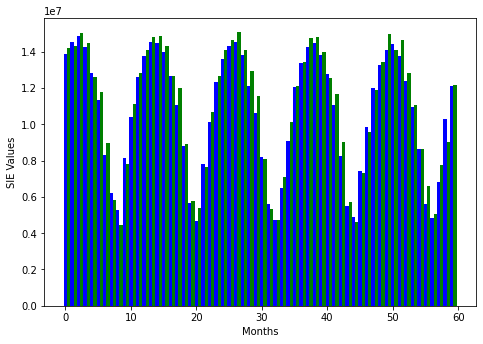

In [54]:
# Plot of test data by month
X = np.arange(len(testPred))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, inv_y_test.flatten(), color = 'b', width = 0.5)
ax.bar(X + 0.5, inv_testPred.flatten(), color = 'g', width = 0.5)
ax.set_xlabel('Months')
ax.set_ylabel('SIE Values')

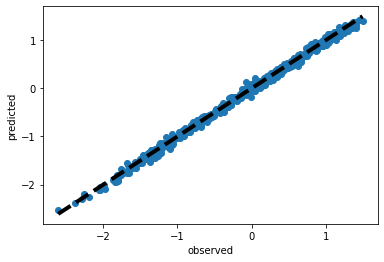

In [55]:
# Scatter plot of predicted and observed values for train set
fig, ax = plt.subplots()
ax.scatter(y_train, trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

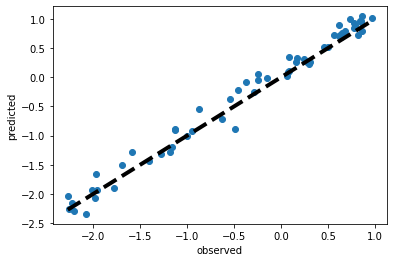

In [56]:
# Scatter plot of predicted and observed values for test set
fig, ax = plt.subplots()
ax.scatter(y_test, testPred) #[:,:,6]
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

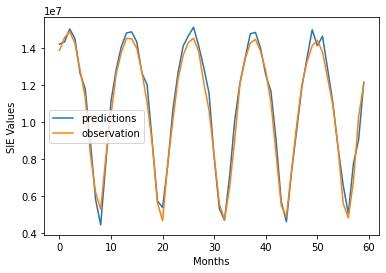

In [57]:
# Plot of observed and predictions for test set
plt.plot(inv_testPred, label='predictions')
plt.plot(inv_y_test, label='observation')
plt.legend()
plt.xlabel("Months")
plt.ylabel("SIE Values")
plt.show()

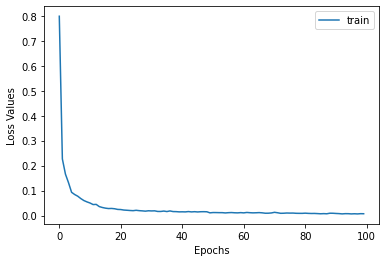

In [58]:
# Plot of training loss
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.show()